# Topic Modeling Using Latent Dirichlet Allocation (LDA)

This notebook applies Latent Dirichlet Allocation (LDA) using scikit-learn's LDA implementation to extract topics from the `all-the-news-25k.csv` dataset.

## Setup

In [1]:
import pandas as pd

df = pd.read_csv('data/all-the-news-25K.csv', low_memory=False, parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         25000 non-null  datetime64[ns]
 1   year         25000 non-null  int64         
 2   month        25000 non-null  float64       
 3   day          25000 non-null  int64         
 4   title        25000 non-null  object        
 5   article      25000 non-null  object        
 6   section      25000 non-null  object        
 7   publication  25000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.5+ MB


In [2]:
df.sample(5)

,date,year,month,day,title,article,section,publication
19618,2017-08-30 00:00:00,2017,8.0,30,Samsung launches swim-tracking Gear Fit2 Pro a...,"Accompanying the new Gear Sport smartwatch, Sa...",technology,The Verge
15037,2019-07-15 00:00:00,2019,7.0,15,U.S. recorded 14 new cases of measles last week,July 15 (Reuters) - The United States recorded...,healthcare,Reuters
9036,2018-02-22 00:00:00,2018,2.0,22,Ice hockey: American Lamoureux sisters spell d...,"GANGNEUNG, South Korea (Reuters) - The Canadia...",sports,Reuters
2118,2018-03-23 14:15:00,2018,3.0,23,"DGB Grab Bag: Weed in the Neutral Zone, Goalie...",The third star: Adam Cracknell – The veteran ...,sports,Vice
24217,2019-06-28 09:37:00,2019,6.0,28,Tom Holland 'Heartbroken' Over Paltrow's Forge...,Tom Holland is just a little upset Gwyneth Pal...,movies,People


## Model Fitting

Use [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to convert to a matrix of token counts:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words="english")
X = vec.fit_transform(df['article'])

Use [sklearn.decomposition.LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to fit an LDA model (takes <1 minute to run):

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=5, # assuming the number of topics is 5
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42
)
lda.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=5, random_state=42)

## Results

Define a function to plot top words (slightly modified [this example](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)):

In [12]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

Plot the model's topics and top words:

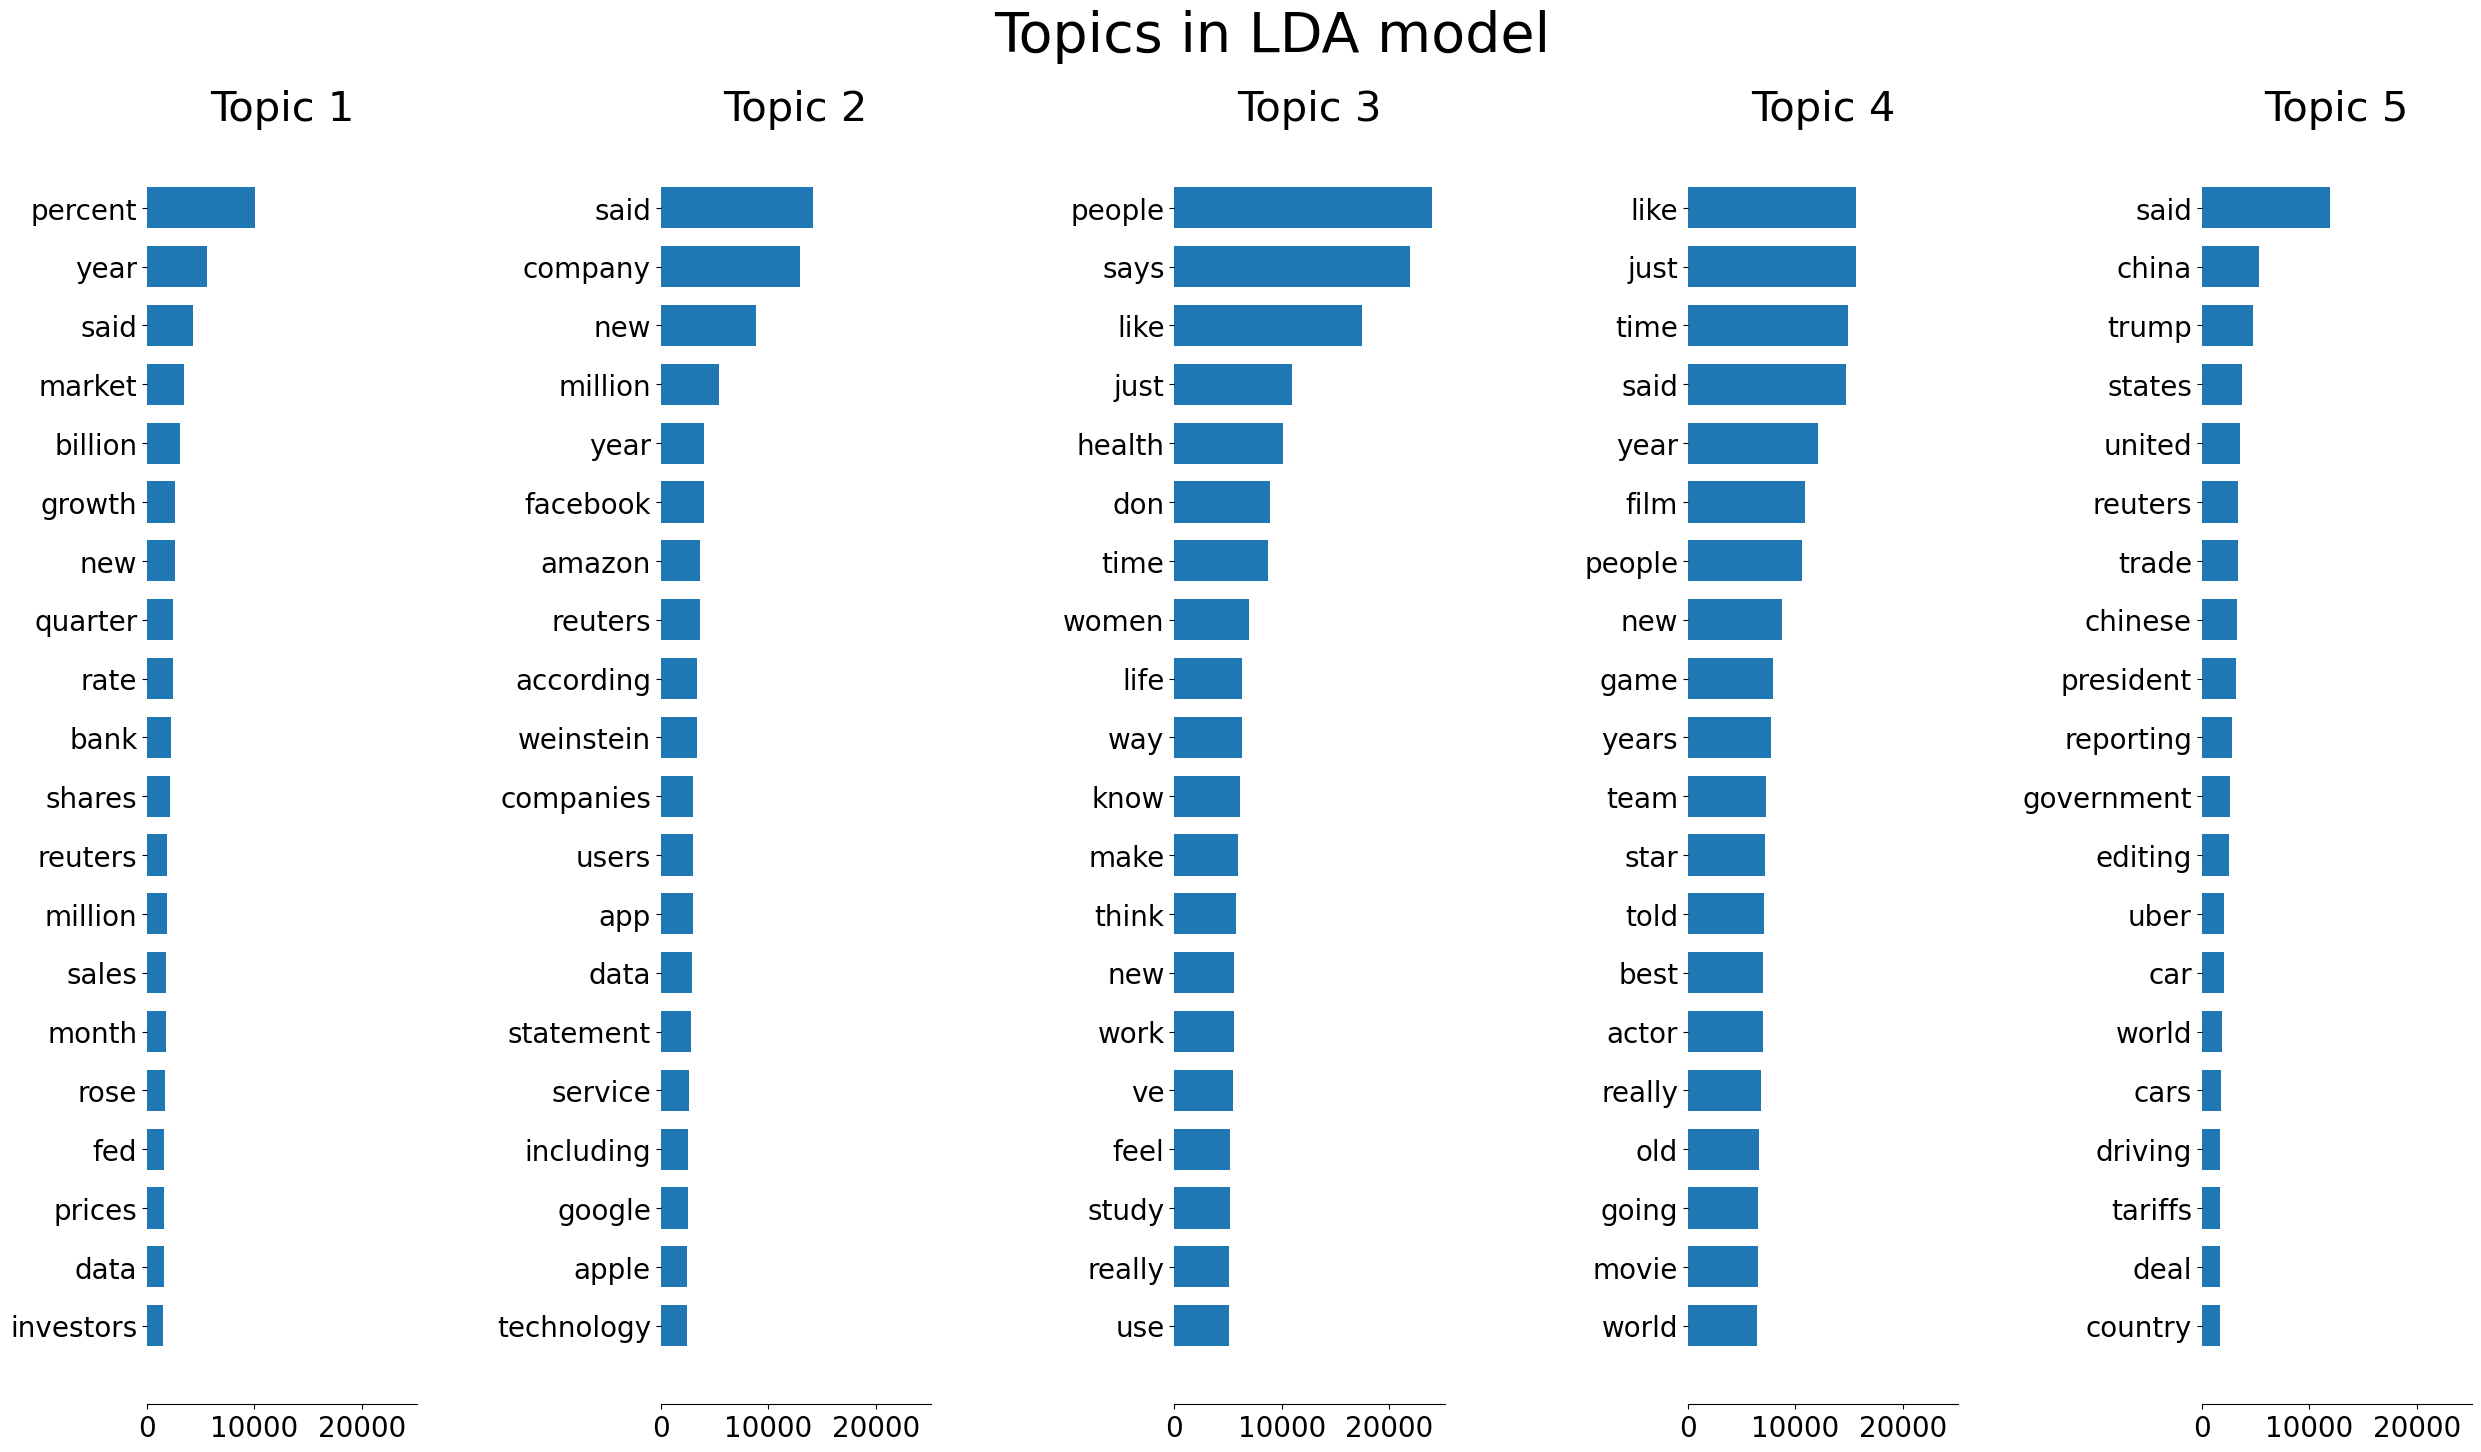

In [13]:
feature_names = vec.get_feature_names_out()
plot_top_words(lda, feature_names, 20, "Topics in LDA model")

Looking at the top words for each topic,
- Topic 1 could be "finance" or "business"
- Topic 2 could be "technology"
- Topic 3 could be "healthcare"
- Topic 4 could be "movies" or "sports"
- Topic 5 could be "business" or "politics" or "world news"

## UMass Coherence Score

Calculate model coherence using tmtoolkit's [metric_coherence_gensim](https://tmtoolkit.readthedocs.io/en/latest/api.html?highlight=metric_coherence#tmtoolkit.topicmod.evaluate.metric_coherence_gensim), which supports models from scikit-learn:

In [21]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

umass_scores = metric_coherence_gensim(
    measure='u_mass', 
    topic_word_distrib=lda.components_, 
    dtm=X, 
    vocab=np.array([x for x in vec.vocabulary_.keys()])
)
umass_scores

[-1.5634767103459515,
 -2.0674821585304004,
 -0.9905286577921222,
 -1.2807534491044528,
 -1.691265731137158]

A list of coherence values for each topic is returned. Take the mean of their values:

In [22]:
np.mean(umass_scores)

-1.5187013413820172

There is no "good" or "bad" coherence score since it depends on the dataset; instead, we just want to maximize the coherence score. Typically, the coherence score increases as the number of topics increase, so there is a trade-off between the coherence score and the number of topics.

For future work, moving away from scikit-learn to specific topic modeling libraries such as gensim may be advisable to take advantage of other features.